## Classifying a phase transition in the XXZ model

In [4]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
import qiskit.extensions.quantum_initializer as qeqi
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib.pyplot as plt
import scipy.sparse.linalg as SPLA
import csv
import pandas as pd
from functools import reduce
from copy import copy, deepcopy

import sys
sys.path.append("..")

import Entangler
import TensorNetwork

import pennylane as qml
import pennylane.numpy as np

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [9, 6]})
plt.rcParams['figure.facecolor'] = 'black'  # For the figure background
plt.rcParams['axes.facecolor'] = 'black'    # For the axes background


In [5]:
cuda = False

In [6]:
n_qubits = 10
wire = list(range(n_qubits))
depth = 4
depth_classifier = 6

ent = Entangler.IsingEntangler()
TN = TensorNetwork.Checkerboard(wire, ent, depth=depth)

TN_classifier = TensorNetwork.Checkerboard(wire, ent, depth=depth_classifier)


tol = 1e-6
method = "L-BFGS-B"
n_max = 100
n_cdata = 2**n_qubits
sv_b = Aer.get_backend("statevector_simulator")
qasm_b = Aer.get_backend("qasm_simulator")
unitary_b = Aer.get_backend('unitary_simulator')

### Loading the data

The data set contains the rows where first 1024 entries are the wavefunction, next 100 are the parameters, then the Jz parameter, energy, and label

In [8]:
filename = "../datasets/vqe_2024-02-20_21-09-05.csv"

df_vqe_2 = pd.read_csv(filename, header=None)
df_vqe_2 = df_vqe_2.applymap(lambda x: complex(x))

df_vqe_2[n_max] = df_vqe_2[n_max].apply(lambda x: x.real)
df_vqe_2[n_max+1] = df_vqe_2[n_max+1].apply(lambda x: x.real)
df_vqe_2[n_max+2] = df_vqe_2[n_max+2].apply(lambda x: x.real)

# df_vqe = df_vqe_2.drop([0, 1])
df_vqe = df_vqe_2

In [5]:
np.shape(df_vqe)

(2000, 103)

### Cleaning the data

In [6]:
df_vqe_clean = df_vqe.sort_values(by=[n_max])
df_vqe_clean.index = np.arange(len(df_vqe))
# df_vqe_clean = df_vqe.sort_index(by=[n_max])

todrop = []
tokeep = []
for i in range(len(df_vqe) // 2):
    E_1 = df_vqe_clean.iloc[i * 2, n_max + 1]
    E_2 = df_vqe_clean.iloc[i * 2 + 1, n_max + 1]
    h_1 = df_vqe_clean.iloc[i * 2, n_max]
    h_2 = df_vqe_clean.iloc[i * 2 + 1, n_max]
#     print(h_1, h_2)
#     print(E_1, E_2)
#     print("====")
    if (E_2 > E_1):
        todrop.append(i * 2 + 1)
        tokeep.append(i * 2)
    else:
        todrop.append(i * 2)
        tokeep.append(i * 2 + 1)

        
for i in range(len(df_vqe) // 2):
    E_kept = df_vqe_clean.iloc[tokeep[i], n_max + 1]
    E_dropped = df_vqe_clean.iloc[todrop[i], n_max + 1]
    if E_dropped < E_kept:
        print("AAA")

print(df_vqe_clean.iloc[:20, [n_max, n_max + 1]])

print(todrop[:10])
print(tokeep[:10])

print("=============")        
        
df_vqe_clean = df_vqe_clean.drop(todrop)
df_total = df_vqe_clean
print(df_vqe_clean.iloc[:10, [n_max, n_max + 1]])

      100        101
0   0.000 -12.441273
1   0.000 -12.437664
2   0.002 -12.445168
3   0.002 -12.455932
4   0.004 -12.463515
5   0.004 -12.452688
6   0.006 -12.471078
7   0.006 -12.460173
8   0.008 -12.467764
9   0.008 -12.478683
10  0.010 -12.475092
11  0.010 -12.486232
12  0.012 -12.482860
13  0.012 -12.493690
14  0.014 -12.490424
15  0.014 -12.501336
16  0.016 -12.497897
17  0.016 -12.508893
18  0.018 -12.516301
19  0.018 -12.505564
[1, 2, 5, 7, 8, 10, 12, 14, 16, 19]
[0, 3, 4, 6, 9, 11, 13, 15, 17, 18]
      100        101
0   0.000 -12.441273
3   0.002 -12.455932
4   0.004 -12.463515
6   0.006 -12.471078
9   0.008 -12.478683
11  0.010 -12.486232
13  0.012 -12.493690
15  0.014 -12.501336
17  0.016 -12.508893
18  0.018 -12.516301


### Split the data into train and test

In [22]:
df_shuffled = df_total.sample(frac=1).reset_index(drop=True)
train_pos = int(0.8 * len(df_total))
test_pos = int(1 * len(df_total))
df_train = df_shuffled.iloc[:train_pos,:]
df_test = df_shuffled.iloc[train_pos:test_pos,:]

df_train_data = np.array(df_train[:-3]) # will cut of the last 3 elements in circuit
df_train_label = np.array(df_train[n_max+2])
df_test_data = np.array(df_test[:-3]) # will cut of the last 3 elements in circuit
df_test_label = np.array(df_test[n_max+2])


### Constructing objective functions

In [23]:
if cuda == True:
    dev = qml.device("lightning.gpu",wire)
else:
    dev = qml.device("default.qubit",wire)
    
@qml.qnode(dev)
def circuit(params, weights):
    TN.construct_circuit(params) # build the ground state, embed the train data
    TN_classifier.construct_circuit(weights)
    return qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7)@qml.PauliZ(8)@qml.PauliZ(9))
    
def variational_classifier(weights, bias, params):
    return circuit(params[:n_max], weights) + bias

def loss_fn(labels, predictions):
    return sum((labels - predictions)**2)/len(labels)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, train_data, labels):
    predictions = [variational_classifier(weights, bias, params) for params in train_data]
    return loss_fn(labels, predictions)


### Construct the QNN Network

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, jaccard_score
from sklearn.metrics import classification_report, confusion_matrix

# Additional torch-related imports
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
from torch import cat, no_grad, manual_seed
from torch.nn import NLLLoss
import torch.nn.functional as F

In [25]:
np.random.seed = 42

NUM_QUBITS = 3
NUM_SHOTS = 3000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

In [26]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()[:-1]

['000', '001', '010', '011', '100', '101', '110']


In [27]:
class QuCircuit():
    def __init__(self, n_qubits, shots):
        # --- Circuit definition ---
        self.n_qubits = n_qubits
        self.shots = shots        
        
    def N_qubit_expectation_Z(self,counts, shots):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        self.dev = qml.device("default.qubit",wires=self.n_qubits, shots=self.shots)
            
        @qml.qnode(self.dev)
        def NNcircuit(params):
            for idx in range(self.n_qubits):
                qml.Hadamard(wires=idx)
                qml.RY(params[idx], wires=idx)
            #qml.CNOT([0, 1])
            #qml.CNOT([1, 2])
            return qml.counts()
        counts = NNcircuit(params=params)
        return self.N_qubit_expectation_Z(counts,self.shots)

/Users/felixxu/anaconda3/envs/Qc/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


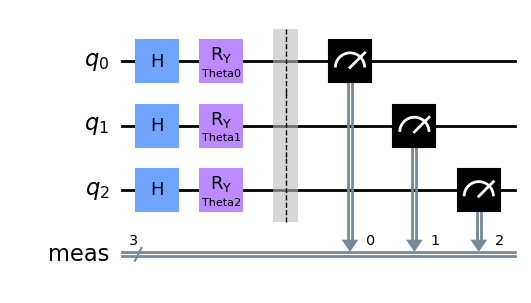

In [18]:
import pennylane as qml
from qiskit.circuit import Parameter
dev = qml.device("default.qubit",wires=3, shots=3000)
            
@qml.qnode(dev)
def NNcircuit(params):
    for idx in range(3):
        qml.Hadamard(wires=idx)
        qml.RY(params[idx], wires=idx)
    return qml.counts()
drawer = qml.draw(NNcircuit)

from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.h(range(3))
theta = {k : Parameter('Theta'+str(k))for k in range(3)}
for k, v in theta.items():
    qc.ry(v, k)
qc.measure_all()

qc.draw('mpl')

In [28]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QuCirc'):
            ctx.QuCirc = QuCircuit(NUM_QUBITS, shots=NUM_SHOTS)
            
        exp_value = ctx.QuCirc.run(i)
        result = torch.tensor(exp_value)
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        _, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = ctx.QuCirc.run(shift_right)
            expectation_left  = ctx.QuCirc.run(shift_left)
            gradient = torch.tensor(expectation_right - expectation_left).float()

            gradients = torch.cat((gradients, gradient.unsqueeze(0)))
            
        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T    

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

NUM_QUBITS = 3
qc = TorchCircuit.apply

class NewNet(nn.Module):
    def __init__(self):
        super(NewNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 30, kernel_size=100, stride=100)
        self.conv2 = nn.Conv1d(2, 4, kernel_size=5, stride=4,padding=1)
        self.conv3 = nn.Conv1d(4, 8, kernel_size=8, stride=5,padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=1)
        self.pool2 = nn.MaxPool1d(kernel_size=1)
        self.fc1 = nn.Linear(8, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(30, NUM_QUBITS)
        self.fc4 = nn.Linear(7, 1)
        self.bn = nn.BatchNorm1d(4)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(0)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc3(x)
        
        MODE = 'QC'
    
        if MODE == 'QC': 
            x = qc(x[0]).float()
        else:
            x = self.qcsim(x)
        x = torch.sigmoid(self.fc4(x)).float()
        
        return x
    
    def predict(self, x):
        pred = self.forward(x)
        return pred > 0.5

# define input tensor
input_tensor = torch.tensor([random.random() for _ in range(100)]).float()#torch.rand(1127, requires_grad=True).float()

# instantiate the model
model = NewNet()

# pass input tensor through the model
output = model(input_tensor)

# print output tensor
print(output)

tensor([0.5118], grad_fn=<SigmoidBackward0>)


In [30]:
# Define model, optimizer, and loss function
network = NewNet()
optimizer = optim.Adam(network.parameters(), lr=0.001)
loss_func = nn.BCELoss()

network.train()  # Set model to training mode
epochs = 10

loss_list = []
acc_list = []
for epoch in range(epochs):
    total_loss = 0.0
    total_correct = 0
    
    for i in range(len(df_train_data)):
        # Get the current input and target
        data = torch.tensor(df_train_data[i], dtype=torch.float32)
        target = torch.tensor(df_train_label[i], dtype=torch.float32)
        
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        # Calculating loss
        loss = loss_func(output.squeeze(), target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        predicted = output.data > 0.5
        total_correct += (predicted == target).sum().item()
        
    loss_list.append(total_loss / len(df_train_data))
    acc_list.append(total_correct / len(df_train_data))
    
    print('Training [{:.0f}%]\tLoss: {:.4f}\tAccuracy: {:.2%}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1], acc_list[-1]))


/var/folders/m6/2s70_qgs7_16ts4sn_34n01w0000gn/T/ipykernel_74235/2335723218.py:19: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:299.)
  data = torch.tensor(df_train_data[i], dtype=torch.float32)


Training [10%]	Loss: 0.5297	Accuracy: 90.97%
Training [20%]	Loss: 0.3880	Accuracy: 97.99%
Training [30%]	Loss: 0.3077	Accuracy: 98.24%
Training [40%]	Loss: 0.2421	Accuracy: 97.87%
Training [50%]	Loss: 0.2028	Accuracy: 97.87%
Training [60%]	Loss: 0.1725	Accuracy: 97.99%
Training [70%]	Loss: 0.1608	Accuracy: 97.87%
Training [80%]	Loss: 0.1372	Accuracy: 97.99%
Training [90%]	Loss: 0.1219	Accuracy: 98.37%
Training [100%]	Loss: 0.1106	Accuracy: 97.99%


### Results

In [31]:
from torch import Tensor

accuracy = 0
number = 0
for i in range(len(df_test_data)):
    data = Tensor(df_test_data[i])
    target = Tensor(df_test_label).long()  # convert target to LongTensor
    number +=1
    output = network.predict(data)
    accuracy += (output == target[i].item())*1
accuracy = accuracy[0]

print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 196/197 = 99.49238586425781%
